# IGRINS Data Reduction: Raw Data to PCA

## Full tutorial based on the IGRINS_transit code found at https://github.com/meganmansfield/IGRINS_transit
### This code is currently under heavy development, but the tutorial included here, which can also be found on the GitHub page, will take you from raw data to a principal component analysis. Future updates will include cross-correlation analysis. This tutorial follows the process outlined in run_pipeline.py
### NOTE: This tutorial is based on as-yet-unpublished data. Please do not share the data/results without permission.
### First, let's load the analysis packages

In [1]:
import numpy as np

%load_ext autoreload
%autoreload 2

import make_cube #makes the data cube and calculates barycentric velocity
import wavecal #performs wavelength calibration
import do_pca #performs principal component analysis
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
from astropy import units, constants
import scipy, pickle

import matplotlib.pyplot as plt

from utils import read_input

### Now feed the code all the important parameters.

In [2]:
coords = SkyCoord('13:50:06.24', '-40:50:09.23', unit=(units.deg, units.deg))

In [3]:
coords.ra.deg, coords.dec.deg

(13.835066666666668, -40.83589722222222)

In [4]:
path='/Users/belugawhale/Documents/HIP67522_IGRINS/reduced' #path to the reduced data provided by the IGRINS pipeline package (PLP)
date='20211029' #date of the observations (just used to name folders)
Tprimary_UT='2022-05-04T03:00:00.000' #time of primary transit, which can be found using the Transit and Ephemeris Service tool at https://exoplanetarchive.ipac.caltech.edu/
Per=6.959503 #in days, also from Exoplanet Archive or your favorite planet lookup service
radeg=coords.ra.deg #in degrees
decdeg=coords.dec.deg#in degrees
#note that RA and Dec must be in degrees; here's a helpful converter: http://www.astrouw.edu.pl/~jskowron/ra-dec/
skyorder=1 #set to 1 if the sky frame was observed at the start of the night and 2 if the sky frame was observed at the end of the night
Vsys=-1.109 #Systemic radial velocity in km/s, listed as "gamma" on the Exoplanet Archive

### Now we'll set a couple parameters for trimming the data. I usually start with keeping as much data as possible and looking at the SNR before throwing any out.

In [5]:
badorders=np.array([]) #set which orders will get ignored. Lower numbers are at the red end of the spectrum, and IGRINS has 54 orders
trimedges=np.array([100,-100]) #set how many points will get trimmed off the edges of each order: fist number is blue edge, second number is red edge

### Now we're ready to make our data cube! This function will take in the raw data files and output a cube of data organized by order x file (phase of orbit) x pixels. It also outputs the observed phases and barycentric velocity at each exposure time.

In [6]:
output_dir = '/Users/belugawhale/Documents/HIP67522_IGRINS/'

Making data cube...
Calculating observed phases...
Calculating barycentric velocity...
Mean barycentric velocity during observation period is -16.742 km/s
Orders with SNR<100:  [0, 22, 23, 24, 25, 26, 52, 53]
Orders with 100<SNR<200:  [1, 2, 3, 4, 5, 6, 7, 8, 18, 20, 21, 27, 28, 29, 48, 49, 50, 51]
Orders with <70\% transmittance:  [0, 1, 2, 18, 20, 21, 22, 23, 24, 25, 26, 27, 50, 51, 52, 53]


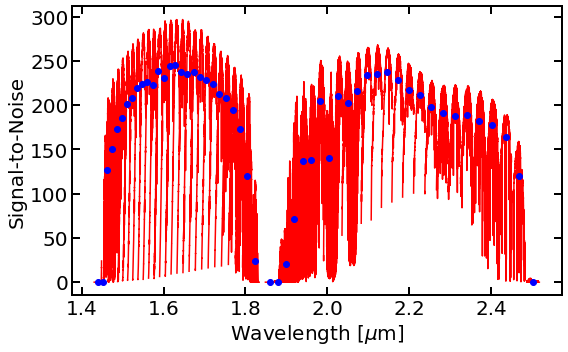

Cleaning data and removing unwanted orders...


In [82]:
phi,Vbary,grid_RAW,data_RAW,wlgrid,data=make_cube.make_cube(path,date,
                                                            Tprimary_UT,
                                                            Per,
                                                            radeg,
                                                            decdeg,
                                                            skyorder,
                                                            exptime=100,
                                                            badorders=badorders, 
                                                            trimedges=trimedges,
                                                            plot=True,
                                                            output=True,
                                                            output_dir=output_dir,
                                                            testorders=True)
#testorders=True will output some information on the SNR of all the orders.
#plot=True will plot the SNR over each order
#output=True will save 3 pickle files for future data processing (not necessary if you stay within this pipeline, but useful if you want to port information to your own data analysis process):
#phi.pic has observed phases
#Vbary.pic has barycentric velocities
#data_raw_OBSDATE.pic has [wavelength grid, raw data (no orders removed), skyorder parameter]

### Now we have to perform a wavelength calibration. The function here just assumes the image taken closest to the sky calibration has "true" wavelengths and does a simple shift/stretch to fit each subsequent spectrum to the template spectrum.

Performing wavelength calibration...


/Users/belugawhale/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/belugawhale/Documents/GitHub/IGRINS_transit/wavecal.py:38: RuntimeWarning: invalid value encountered in true_divide
  data_to_correct = data_to_correct/data_to_correct.max() #normalize


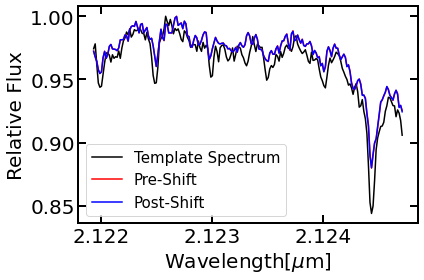

In [83]:
wlgrid,wavecorrect=wavecal.correct(wlgrid,data,
                                   skyorder,
                                   plot=True,
                                   output_dir=output_dir,
                                   output=True)
#plot=True will plot a zoom-in on one of the orders so you can see the results of the wavelength calibration and check them by eye
#output=True will save a file called wavelengthcalibrated.pic that contains [wavelength array, wavelength calibrated data cube]

### Now we can perform a principal component analysis! 

In [7]:
%load_ext autoreload
%autoreload 2

import make_cube #makes the data cube and calculates barycentric velocity
import wavecal #performs wavelength calibration
import do_pca #performs principal component analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


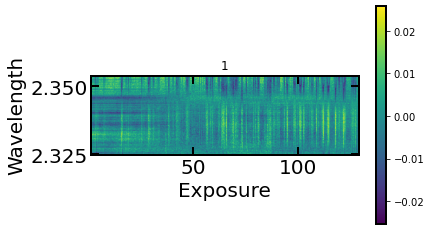

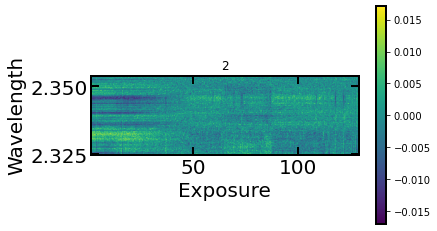

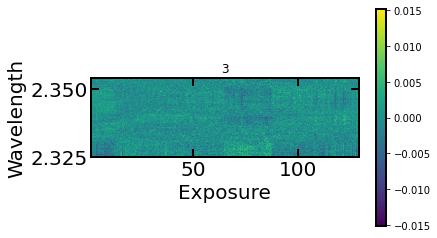

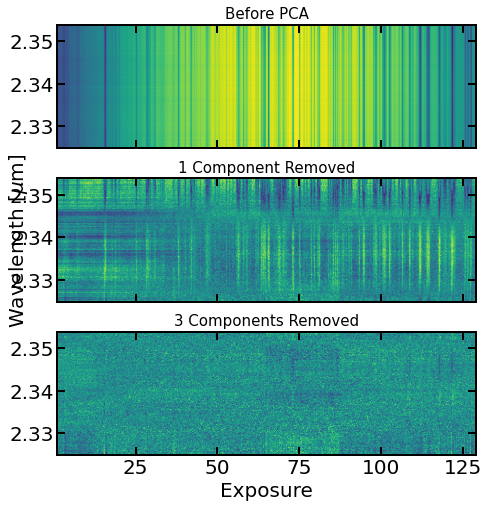

In [84]:
nPCAs=3 #number of principal components to subtract (or maximum value for test_pca)
wlgrid,pca_clean_data,pca_noplanet=do_pca.do_pca(wlgrid,
                                                 wavecorrect,
                                                 nPCAs,
                                                 test_pca=True,
                                                 plot=True,
                                                 output_dir=output_dir,
                                                 output=True)
#test_pca=True will go through removing every number of PCs from 1 to nPCAs, plotting the cleaned results each time
#plot=True will show a plot comparing the raw data, data with 1 PC removed, and data with nPCAs removed
#output=True will save two pickle files:
#PCA_n_clean_data.pic contains [wavelength array, cleaned data] where cleaned data have n PCs removed
#PCA_n_noise.pic contains [wavelength array, removed noise] where removed noise is all the signal contained in the first n PCs

Text(0, 0.5, 'Summed Flux')

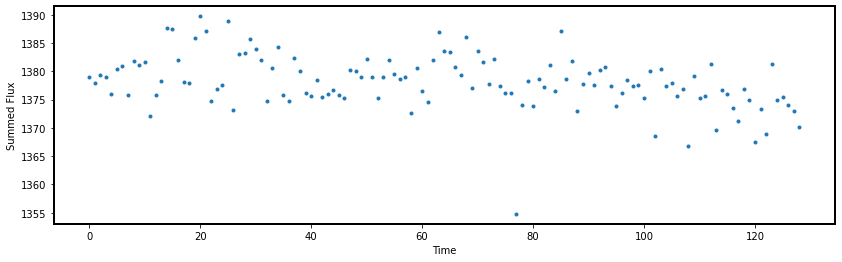

In [102]:
q = (wlgrid[9]>2.212) & (wlgrid[9]<2.2124)
plt.figure(figsize=(14,4))
plt.plot(np.nansum(pca_noplanet[11,:,:], axis=1),'.')
plt.xlabel('Time')
plt.ylabel('Summed Flux')

## Tests
- At this point I would make CCF maps for 3 and 4 components and see if you can see any structure in them. The planet should show up at around the expected Kp and Vsys, but if you have leftover tellurics or stellar signal that could show up as a blob at unexpected Kp and Vsys (like the star would be at a similar Vsys but a Kp near 0). Ultimately the retrieval shouldn’t depend in too much detail on the number of components you subtract - or at least the conclusions you can call “firm” shouldn’t. So at this point it looks like any good conclusions you can draw from the data should be similar with 3 or 4 components.


In [103]:
from utils import *
params = read_input()

In [104]:
def get_rot_ker(vsini, wStar):
    nx, = wStar.shape
    dRV = np.mean(2.0*(wStar[1:]-wStar[0:-1])/(wStar[1:]+wStar[0:-1]))*2.998E5
    nker = 401
    hnker = (nker-1)//2
    rker = np.zeros(nker)
    for ii in range(nker):
        ik = ii - hnker
        x = ik*dRV / vsini
        if np.abs(x) < 1.0:
            y = np.sqrt(1-x**2)
            rker[ii] = y
    rker /= rker.sum()

    return rker

In [137]:
def log_likelihood_PCA(Vsys, Kp, scale, cs_p, wlgrid, data_arr):

    Ndet, Nphi, Npix = data_arr.shape

    I = np.ones(Npix)
    N = Npix#np.array([Npix])

    # Time-resolved total radial velocity
    RV = Vsys + Rvel + Kp*np.sin(2.*np.pi*ph)  # Vsys is an additive term around zero
    dl_l = RV*1e3 / constants.c

    # Initializing log-likelihoods and CCFs
    logL_Matteo = 0.
    logL_Zuck = 0.
    CCF = 0.

    for j in range(Ndet):
        wCut = wlgrid[j,].copy() # Cropped wavelengths
        gTemp=np.zeros((Nphi,Npix))  #"shifted" model spectra array at each phase
        for i in range(Nphi):
            wShift = wCut * (1.0 - dl_l[i].value)
            Depth_p = scipy.interpolate.splev(wShift, cs_p, der=0) * scale
            gTemp[i,] = Depth_p

        fData=(1.-gTemp)
        #faster SVD
        u,ss,vh=np.linalg.svd(fData,full_matrices=False) 
        ss[0:4]=0. 
        W=np.diag(ss)
        A=np.dot(u,np.dot(W,vh))
        gTemp=A

        for i in range(Nphi):
            gVec=gTemp[i,].copy()
            gVec-=(gVec.dot(I))/float(Npix)  #mean subtracting here...
            sg2=(gVec.dot(gVec))/float(Npix)
            fVec=data_arr[j,i,].copy() # already mean-subtracted
            sf2=(fVec.dot(fVec))/Npix
            R=(fVec.dot(gVec))/Npix # cross-covariance
            CC=R/np.sqrt(sf2*sg2) # cross-correlation
            CCF+=CC
            logL_Matteo+=(-0.5*N * np.log(sf2+sg2-2.0*R))
            logL_Zuck+=(-0.5*N * np.log (1.0 - CC**2.0))


    return logL_Matteo, logL_Zuck, CCF

In [138]:
Ndet, Nphi, Npix = pca_clean_data.shape

In [139]:
fcomp = 10**((8.243-params['Kmag'])/-2.5)
if fcomp < 1:
    fcomp = 10**((8.243-params['Kmag'])/2.5)
if fcomp < 1:
    print('Returning a comparison flux < 1')
    sys.exit()
scale= params['Dur']/3.6936 * fcomp

In [140]:
model_path = '/Users/belugawhale/Documents/HIP67522_IGRINS/models/'
wl_model, Depth = np.loadtxt(os.path.join(model_path,params['model'])).T

Rvel =pickle.load(open('Vbary.pic','rb'))
ph = pickle.load(open('phi.pic','rb')) 

In [146]:
ind=0
nKp=100 #number of KP points. Will have to change if change velocity resolution
dRV=1 #velocity resolution (note, if you change it you will have to change array stuff below)

#creating KP/Vsys arrays (does all Kp's along a "Vsys Slice")
Kparr=(np.arange(nKp) - (nKp-1)//2) * dRV + params['Kp'] #builds "symetric" array about some nominal specified Kp
start=-200 #starting Vsys value
delta=1 #how many "Vsys slices" to do on one CPU
Vsysarr=np.arange(start+delta*ind,start+delta*(ind+1),dRV)
name='part_'+str(ind)

logLarr=np.zeros((len(Kparr),len(Vsysarr)))
CCFarr=np.zeros((len(Kparr),len(Vsysarr)))

Kp = 100
Vsysarr=np.arange(100,101,dRV)

xker = np.arange(41)-20
sigma = 5.5/(2.* np.sqrt(2.0*np.log(2.0)))  #nominal

yker = np.exp(-0.5 * (xker / sigma)**2.0)
yker /= yker.sum()
Fp_conv = np.convolve(Depth,yker,mode='same')
cs_p = scipy.interpolate.splrep(wl_model,Fp_conv,s=0.0)

In [151]:
for i in range(len(Kparr)):
    for j in range(len(Vsysarr)):
        logL_M, logL_Z, CCF1=log_likelihood_PCA(Vsysarr[j], Kparr[i],
                                                scale, cs_p, 
                                                wlgrid,
                                                pca_clean_data)
        logLarr[i,j]=logL_M
        CCFarr[i,j]=CCF1

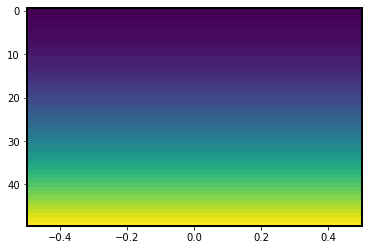

In [179]:
from astropy.stats import sigma_clipped_stats, sigma_clip
xlimm=-1
ylimm=10
mean, med, sc = sigma_clipped_stats(CCFarr,sigma_lower=3.,sigma_upper=3.)
CCFarr1=(CCFarr-med)/sc
CCFarr1[ylimm:-20,140:xlimm]=0


#CCFarr1=CCFarr1[::-1,:]
#CCFarr1=CCFarr1-np.mean(CCFarr1)
#stdev1=np.std(CCFarr1[ylimm:-20,140:xlimm])
#maxx1=(CCFarr1/stdev1).max()
#loc1=np.where(CCFarr1/stdev1 == maxx1)


cax=plt.imshow(CCFarr1[50:],# extent=[-50,50, Kparr.min(),Kparr.max()],
                aspect="auto",interpolation='none')
